In [1]:
%pylab inline
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
from __future__ import division 
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

Populating the interactive namespace from numpy and matplotlib


In [16]:
df = pd.read_csv('../input/data.csv')

In [17]:
df['label'] = np.where(df['StateWinner.2016']=="T", 1, 0)
df['rep_2012'] = np.where(df['Obama.2012']<df['Romney.2012'], 1, 0)
df['over_average_obesity'] = np.where(df['ObesityRate'] > mean(df['ObesityRate']), 1, 0)

In [18]:
variables = ['State', 'TotalVotingPopulation',
 'Age.18_29',
 'Age.30_44',
 'Age.45_64',
 'Age.Over65',
 'Male',
 'Female',
 'White',
 'AfricanAmerican',
 'AmericanIndian',
 'Asian',
 'Pacific',
 'Latino',
 'NotLatino',
 'CollegeEducation',
 'PovertyRate',
 'HouseholdIncomeOver100k',
 'ObesityRate',
 'GunOwnership',
 'UnemploymentRate'
             , 'over_average_obesity'
#  'TotalVote.2012',
#  'Obama.2012',
#  'Romney.2012',
#  'Others.2012', 'rep_2012'
             , 'label']
swing_states = ['Florida', 'Iowa', 'Michigan'
                , 'Nevada', 'NewHampshire'
                , 'NewMexico', 'NorthCarolina', 'Ohio', 'Pennsylvania'
                , 'Virginia', 'Wisconsin']

In [19]:
df = df[variables]

In [20]:
df_training = df[df['State'].apply(lambda x: x not in swing_states)]

In [21]:
df_testing = df[df['State'].apply(lambda x: x in swing_states)]

In [22]:
for df in [df_testing, df_training]:
    isnan_rows = df.isnull().any(axis = 1)
    nrows = df.shape[0]
    nrows_isnan = df[isnan_rows].shape[0]
    print(nrows)
    print(nrows_isnan)
    print('% of rows with NaN: {}'.format(float(nrows_isnan)/nrows))
    df = df[~isnan_rows]

11
0
% of rows with NaN: 0.0
40
0
% of rows with NaN: 0.0


## Imputation

In [23]:
df_training.describe()

,TotalVotingPopulation,Age.18_29,Age.30_44,Age.45_64,Age.Over65,Male,Female,White,AfricanAmerican,AmericanIndian,...,Latino,NotLatino,CollegeEducation,PovertyRate,HouseholdIncomeOver100k,ObesityRate,GunOwnership,UnemploymentRate,over_average_obesity,label
count,4.000000e+01,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,4.054137e+06,0.217625,0.240425,0.341750,0.200175,0.487425,0.512575,0.791700,0.112000,0.015225,...,0.071000,0.929000,0.311450,0.121075,0.249275,0.292925,0.336050,0.046925,0.550000,0.575000
std,4.870685e+06,0.021824,0.017802,0.021117,0.021400,0.013235,0.013235,0.143697,0.117417,0.025863,...,0.067258,0.067258,0.069357,0.026630,0.073244,0.042731,0.144051,0.010032,0.503831,0.500641
min,4.345840e+05,0.175000,0.208000,0.265000,0.132000,0.466000,0.465000,0.295000,0.004000,0.001000,...,0.010000,0.714000,0.193000,0.082000,0.140000,0.202000,0.052000,0.028000,0.000000,0.000000
25%,1.047984e+06,0.207500,0.231000,0.334750,0.191500,0.477750,0.507500,0.709750,0.033000,0.003000,...,0.025750,0.919000,0.265000,0.098750,0.188500,0.255250,0.250750,0.040000,0.000000,0.000000
50%,2.881890e+06,0.214500,0.239000,0.344000,0.204000,0.485500,0.514500,0.820500,0.065500,0.005000,...,0.053500,0.946500,0.305000,0.119000,0.229500,0.299000,0.322500,0.049500,1.000000,1.000000
75%,4.747035e+06,0.221500,0.246250,0.351250,0.212250,0.492500,0.522250,0.893000,0.152000,0.012000,...,0.081000,0.974250,0.345000,0.137750,0.296000,0.324000,0.444250,0.053250,1.000000,1.000000
max,2.500281e+07,0.290000,0.297000,0.380000,0.234000,0.535000,0.534000,0.962000,0.481000,0.129000,...,0.286000,0.990000,0.569000,0.189000,0.395000,0.362000,0.617000,0.068000,1.000000,1.000000


In [24]:
# np.unique(df_training['feat'])
# mask = ((df_training['feat']<0)|(df_training['feat']>100))
# vals_to_replace = df_training[mask]['feat'].values
# df_training['feat'].replace(vals_to_replace, np.NaN, inplace = True)
# df_training['feat'].unique
# mean = df_training['feat'].mean()
# df_training['feat'].fillna(mean, inplace = True)

## Checking Balance

In [25]:
print('Number of rows: {}'.format(df_training.shape[0]))
df_training['label'].value_counts(normalize = True)

Number of rows: 40


1    0.575
0    0.425
Name: label, dtype: float64

## Scaling Values

In [26]:
to_scale = ['TotalVotingPopulation',
            'Age.18_29',
            'Age.30_44',
            'Age.45_64',
            'Age.Over65',
            'Male',
            'Female',
            'White',
            'AfricanAmerican',
            'AmericanIndian',
            'Asian',
            'Pacific',
            'Latino',
            'NotLatino',
            'CollegeEducation',
            'PovertyRate',
            'HouseholdIncomeOver100k',
            'ObesityRate',
            'GunOwnership',
            'UnemploymentRate',
#             'TotalVote.2012'
#             'Obama.2012',
#             'Romney.2012',
#             'Others.2012'
           ]

In [27]:
for df in [df_testing, df_training]:
    for feature in to_scale:
        max_feature = df[feature].max()
        min_feature = df[feature].min()
        df[feature] = (df[feature]-min_feature)/(max_feature-min_feature)

## Crosstabs

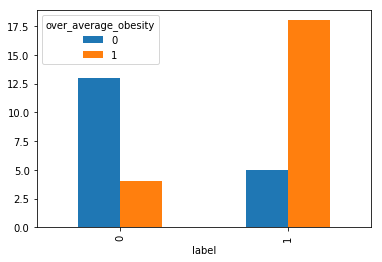

In [28]:
pd.crosstab(index = df_training['label']
            , columns = df_training['over_average_obesity']
           ).plot(kind = 'bar')

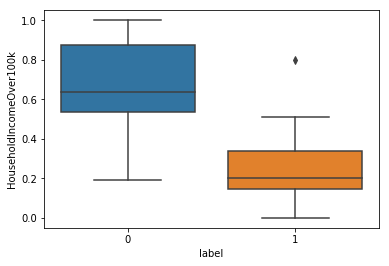

In [30]:
ax = sns.boxplot(x = "label", y = "HouseholdIncomeOver100k", data = df_training)

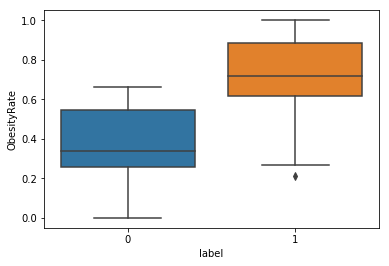

In [31]:
ax = sns.boxplot(x = "label", y = "ObesityRate", data = df_training)

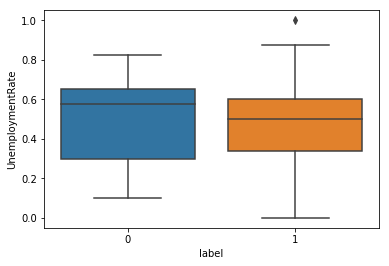

In [32]:
ax = sns.boxplot(x = "label", y = "UnemploymentRate", data = df_training)

## Splitting Features and Labels

In [34]:
sel_features = ['TotalVotingPopulation',
 'Age.18_29',
 'Age.30_44',
 'Age.45_64',
 'Age.Over65',
 'Male',
 'Female',
 'White',
 'AfricanAmerican',
 'AmericanIndian',
 'Asian',
 'Pacific',
 'Latino',
 'NotLatino',
 'CollegeEducation',
 'PovertyRate',
 'HouseholdIncomeOver100k',
 'ObesityRate',
 'GunOwnership',
 'UnemploymentRate', 'over_average_obesity']
sel_labels = 'label'

In [35]:
X_train = df_training[sel_features].values
y_train = df_training[sel_labels].values
X_test = df_testing[sel_features].values
y_test = df_testing[sel_labels].values

## Logistic Regression

In [36]:
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='l1', C=1e5)
model.fit(X_train, y_train)
print(model)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [37]:
print("Feature coefficients:")
list(zip(sel_features, model.coef_[0]))

Feature coefficients:


[('TotalVotingPopulation', 14.884812796971719),
 ('Age.18_29', 19.932409691684388),
 ('Age.30_44', 12.394516783502356),
 ('Age.45_64', -4.777950522920217),
 ('Age.Over65', -3.556564984991818),
 ('Male', 5.751030795240015),
 ('Female', -1.3278926311199237),
 ('White', -2.090467026345773),
 ('AfricanAmerican', 11.34021230626771),
 ('AmericanIndian', 49.69258720079587),
 ('Asian', -151.92553530516585),
 ('Pacific', 0.0),
 ('Latino', -3.105088906498524),
 ('NotLatino', -0.7537153236288502),
 ('CollegeEducation', -20.251943775695413),
 ('PovertyRate', -4.88182112663324),
 ('HouseholdIncomeOver100k', -14.478963054565098),
 ('ObesityRate', 11.962297881795498),
 ('GunOwnership', 8.933092946559283),
 ('UnemploymentRate', -6.400825329372032),
 ('over_average_obesity', 3.8849221830624505)]

In [38]:
std_coef = np.std(X_test,0)*model.coef_
list(zip(sel_features, std_coef[0]))

[('TotalVotingPopulation', 4.423630502815465),
 ('Age.18_29', 5.856191711643263),
 ('Age.30_44', 3.772748720122398),
 ('Age.45_64', -1.3166606606077607),
 ('Age.Over65', -0.8544409086408257),
 ('Male', 1.5167106971331084),
 ('Female', -0.3502031253129054),
 ('White', -0.721789796387777),
 ('AfricanAmerican', 3.597402598862907),
 ('AmericanIndian', 13.810179955116334),
 ('Asian', -44.07575022656987),
 ('Pacific', 0.0),
 ('Latino', -0.9162843020459455),
 ('NotLatino', -0.22241473273349033),
 ('CollegeEducation', -5.950391956791729),
 ('PovertyRate', -1.2108259359123288),
 ('HouseholdIncomeOver100k', -4.782207135269112),
 ('ObesityRate', 3.784000100047007),
 ('GunOwnership', 2.2184804030003833),
 ('UnemploymentRate', -1.6005845130255674),
 ('over_average_obesity', 1.9344177398322895)]

## Model Evaluation

In [39]:
y_scores = model.predict_proba(X_test)[:,1]

In [40]:
y_scores

array([3.22918885e-08, 1.00000000e+00, 9.99998777e-01, 1.54950917e-50,
       1.73209668e-20, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       3.70802206e-05, 1.14227653e-30, 9.99862556e-01])

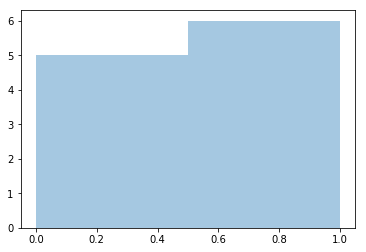

In [41]:
sns.distplot(y_scores, kde = False, rug = False)

In [42]:
df_testing['y_scores'] = y_scores

In [43]:
df_testing[['State', 'label', 'y_scores']]

,State,label,y_scores
9,Florida,1,3.229189e-08
15,Iowa,1,1.000000e+00
22,Michigan,1,9.999988e-01
28,Nevada,0,1.549509e-50
29,NewHampshire,0,1.732097e-20
31,NewMexico,0,1.000000e+00
33,NorthCarolina,1,1.000000e+00
35,Ohio,1,1.000000e+00
38,Pennsylvania,1,3.708022e-05
46,Virginia,0,1.142277e-30


In [48]:
calc_threshold = lambda x,y: 0 if x<y else 1
predicted = np.array([calc_threshold(score, 0.5) for score in y_scores])
expected = y_test

## Confusion Matrix

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
conf_matrix = confusion_matrix(expected, predicted)
print(conf_matrix)

[[3 1]
 [2 5]]


In [51]:
predicted

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])

### Accuracy

$$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN} $$

In [52]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print(accuracy)

0.7272727272727273


### Precision and Recall

$$ Precision = \frac{TP}{TP+FP}$$

$$ Recall = \frac{TP}{TP+FN} $$


In [53]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc
precision = precision_score(expected, predicted)
recall = recall_score(expected, predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.8333333333333334
Recall= 0.7142857142857143


In [54]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.692092


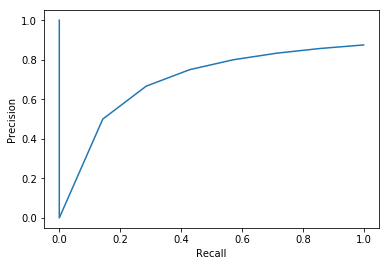

In [55]:
plot_precision_recall(expected, y_scores)

## Precision and Recall at k%

If we only care about a specific part of the precision-recall curve we can focus on more fine-grained metrics. For instance, say there is a special program for people likely to need assistance within the next year , but only *3000 or 1% of the people in our test set*  can be admitted. In that case, we would want to prioritize the 1% who were *most likely* to need assistance within the next year, and it wouldn't matter too much how accurate we were on the 78% or so who weren't very likely to need assistane.

Let's say that, out of the approximately 300,000 peoiple, we can intervene on 1% of them, or the "top" 3000 people in a year (where "top" means highest likelihood of needing assistance in the next year). We can then focus on optimizing our **precision at 1%**.

In [56]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls 
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf()

In [57]:
def precision_at_k(y_true, y_scores,k):
    
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores ])
    return precision_score(y_true, y_pred)

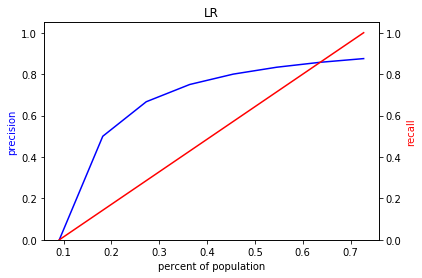

In [58]:
plot_precision_recall_n(expected,y_scores, 'LR')

In [59]:
p_at_1 = precision_at_k(expected,y_scores, 0.01)
print('Precision at 1%: {:.2f}'.format(p_at_1))

Precision at 1%: 0.00


## Survey of Algorithms

*[Go back to Table of Contents](#Table-of-Contents)*

We have only scratched the surface of what we can do with our model. We've only tried one classifier (Logistic Regression), and there are plenty more classification algorithms in `sklearn`. Let's try them! 

In [60]:
clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
       'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SGD':SGDClassifier(loss='log'),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, random_state=17, n_estimators=10),
        'NB': GaussianNB()}

In [61]:
sel_clfs = ['RF', 'ET', 'LR', 'SGD', 'GB', 'NB']


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


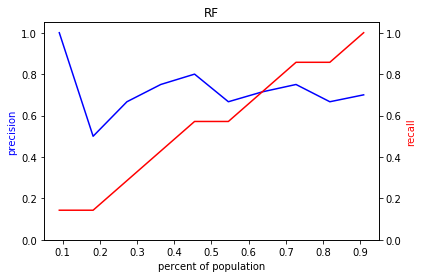

FEATURE IMPORTANCES
{'TotalVotingPopulation': 0.016998583470393635, 'Age.18_29': 0.03612612639447733, 'Age.30_44': 0.015869674805055852, 'Age.45_64': 0.02556901429375409, 'Age.Over65': 0.011974454508879698, 'Male': 0.03789522716159243, 'Female': 0.026268411720918063, 'White': 0.020057120021679014, 'AfricanAmerican': 0.011895500923157791, 'AmericanIndian': 0.023885604660217667, 'Asian': 0.14450282947735255, 'Pacific': 0.010965168676166117, 'Latino': 0.03935790526887758, 'NotLatino': 0.07271469407219394, 'CollegeEducation': 0.14886983628158038, 'PovertyRate': 0.0337401567892796, 'HouseholdIncomeOver100k': 0.08350720372316843, 'ObesityRate': 0.08285720820441461, 'GunOwnership': 0.13190347436146455, 'UnemploymentRate': 0.006431187732654008, 'over_average_obesity': 0.018610617452722716}


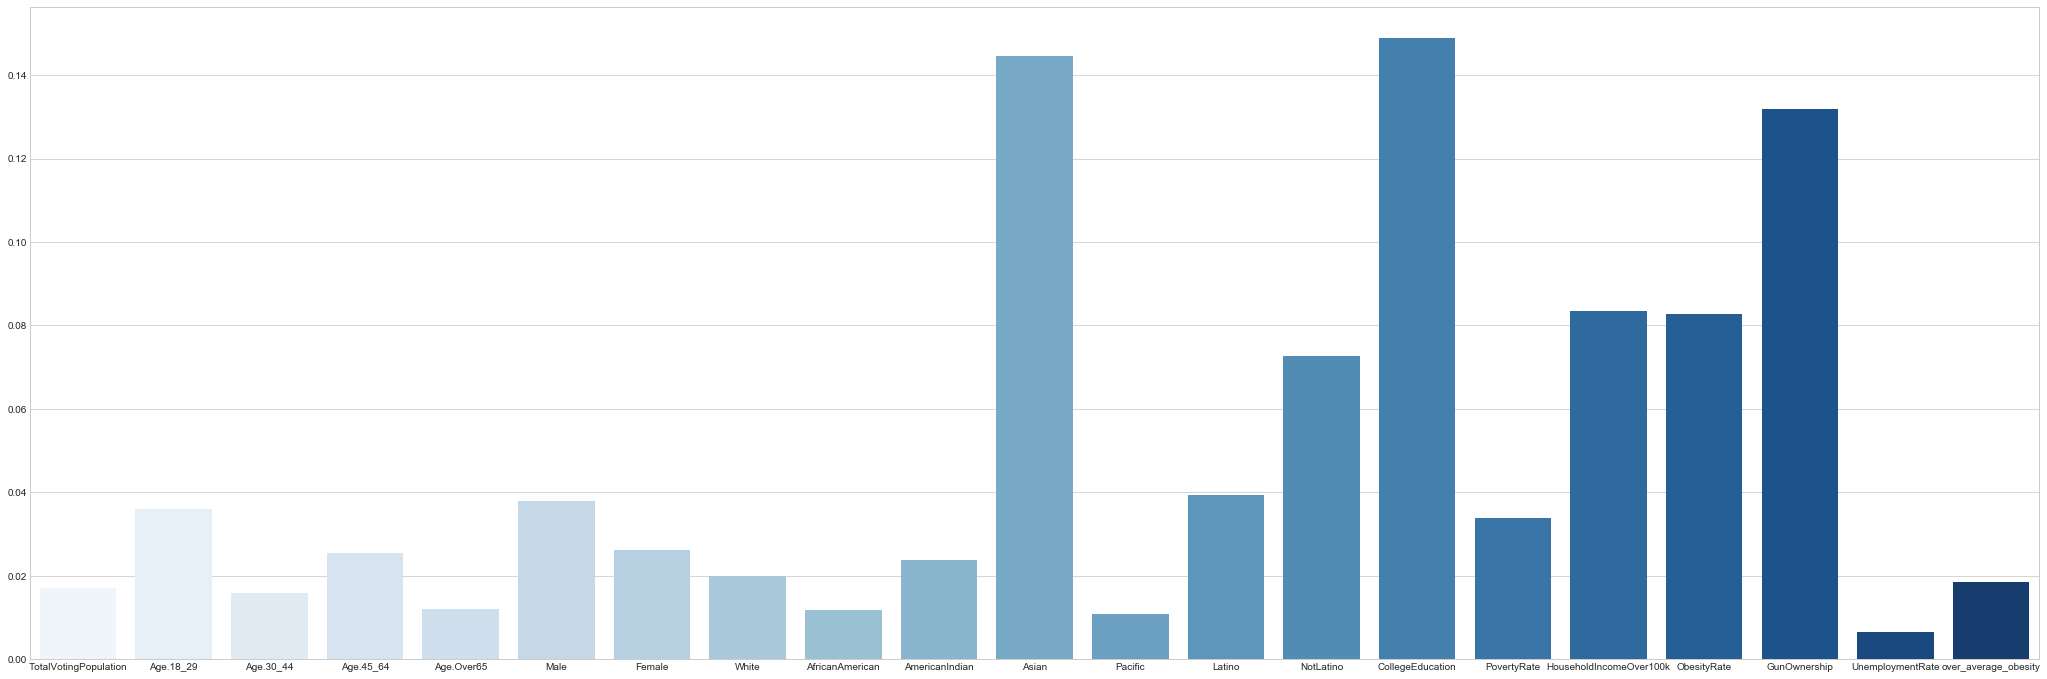

Precision at 1%: 1.00
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


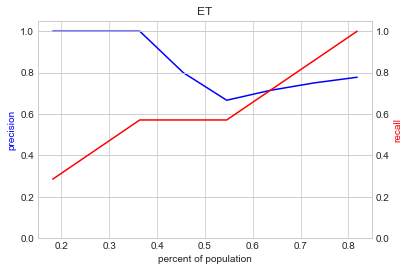

FEATURE IMPORTANCES
{'TotalVotingPopulation': 0.013635449135307284, 'Age.18_29': 0.0160959453908708, 'Age.30_44': 0.04329756276922799, 'Age.45_64': 0.011830291075426097, 'Age.Over65': 0.02170916381173348, 'Male': 0.05642706932783794, 'Female': 0.014366669651425436, 'White': 0.03142325943168521, 'AfricanAmerican': 0.03133875990868955, 'AmericanIndian': 0.055746165522235366, 'Asian': 0.018912234698623232, 'Pacific': 0.016082586855032176, 'Latino': 0.012084089569106457, 'NotLatino': 0.011950512034351962, 'CollegeEducation': 0.17824112678978551, 'PovertyRate': 0.06610990270206633, 'HouseholdIncomeOver100k': 0.11427670756866085, 'ObesityRate': 0.07681039473909736, 'GunOwnership': 0.09262817400992149, 'UnemploymentRate': 0.010165615538629007, 'over_average_obesity': 0.10686831947028641}


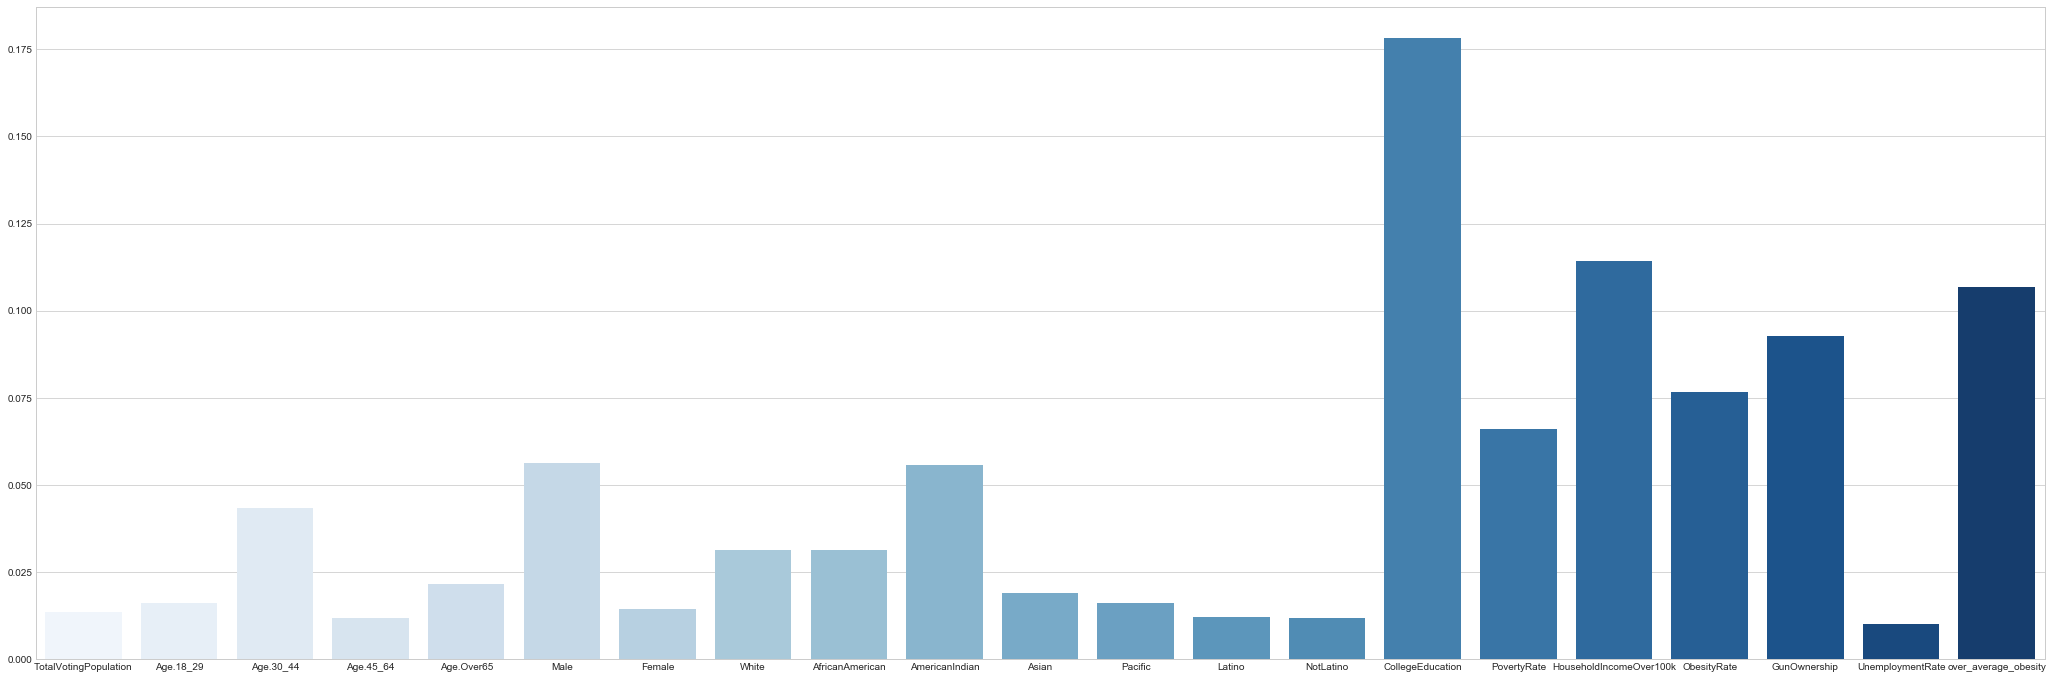

Precision at 1%: 1.00
LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


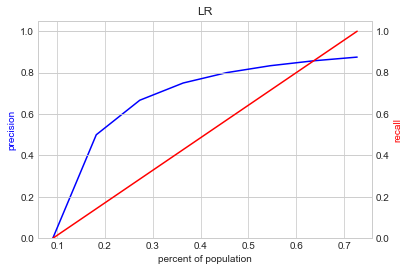

FEATURE IMPORTANCES
{'TotalVotingPopulation': 12.922549575546052, 'Age.18_29': 22.47633319949867, 'Age.30_44': 10.238835071514105, 'Age.45_64': -4.779061537073082, 'Age.Over65': -4.000821858171915, 'Male': 6.29942736841279, 'Female': -1.7519952115031816, 'White': -1.0275991164555154, 'AfricanAmerican': 10.65618021396767, 'AmericanIndian': 40.6914595498977, 'Asian': -149.288730516912, 'Pacific': 0.0, 'Latino': 0.5622470944024218, 'NotLatino': 0.3003520604770256, 'CollegeEducation': -20.31006684829399, 'PovertyRate': -3.915998644472187, 'HouseholdIncomeOver100k': -16.905165952500933, 'ObesityRate': 11.145871291914299, 'GunOwnership': 6.948011599868122, 'UnemploymentRate': -5.204762155209999, 'over_average_obesity': 3.160741785026029}


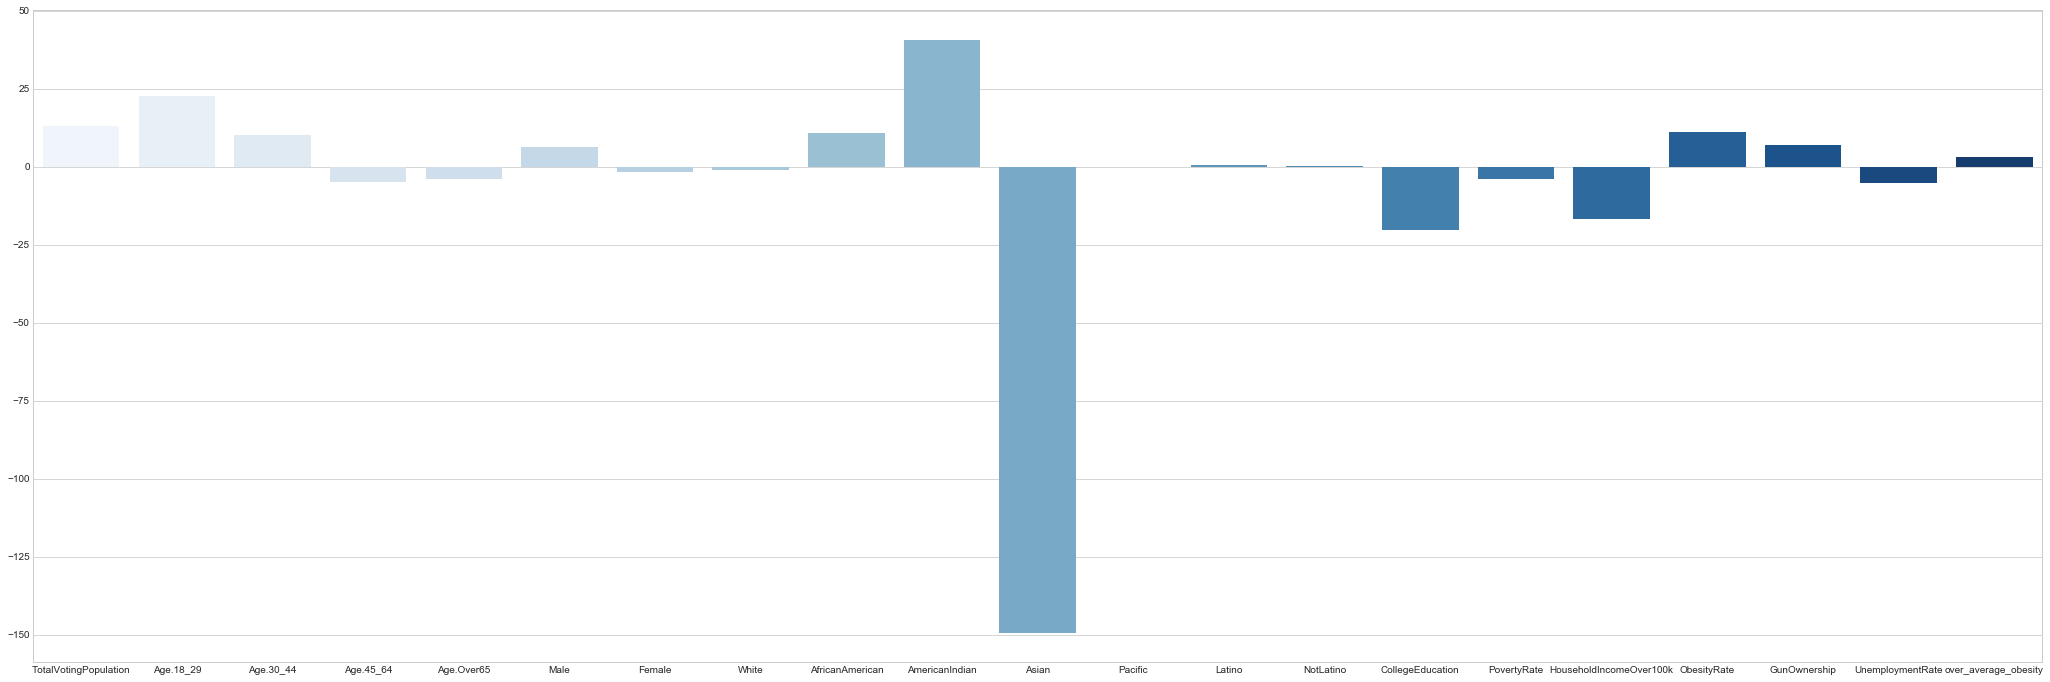

Precision at 1%: 0.00
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


/Users/nj995/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


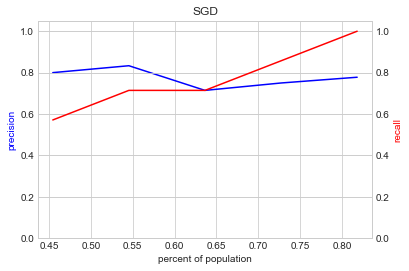

FEATURE IMPORTANCES
{'TotalVotingPopulation': -6.092877081857035, 'Age.18_29': 15.81633268195822, 'Age.30_44': 13.289971739492456, 'Age.45_64': -14.08470074030345, 'Age.Over65': -18.30373895840591, 'Male': 8.345520857802939, 'Female': -10.923195710637339, 'White': 1.2476525116474282, 'AfricanAmerican': 9.136884844065937, 'AmericanIndian': 23.676072212781694, 'Asian': -15.739678567250051, 'Pacific': -8.91976696518828, 'Latino': -0.2345159407745504, 'NotLatino': -2.343158912059883, 'CollegeEducation': -28.160209583694378, 'PovertyRate': 20.17822096017808, 'HouseholdIncomeOver100k': -35.906008546130266, 'ObesityRate': 27.661983150181634, 'GunOwnership': 39.19807480536314, 'UnemploymentRate': -6.417281394690827, 'over_average_obesity': 19.905378320684118}


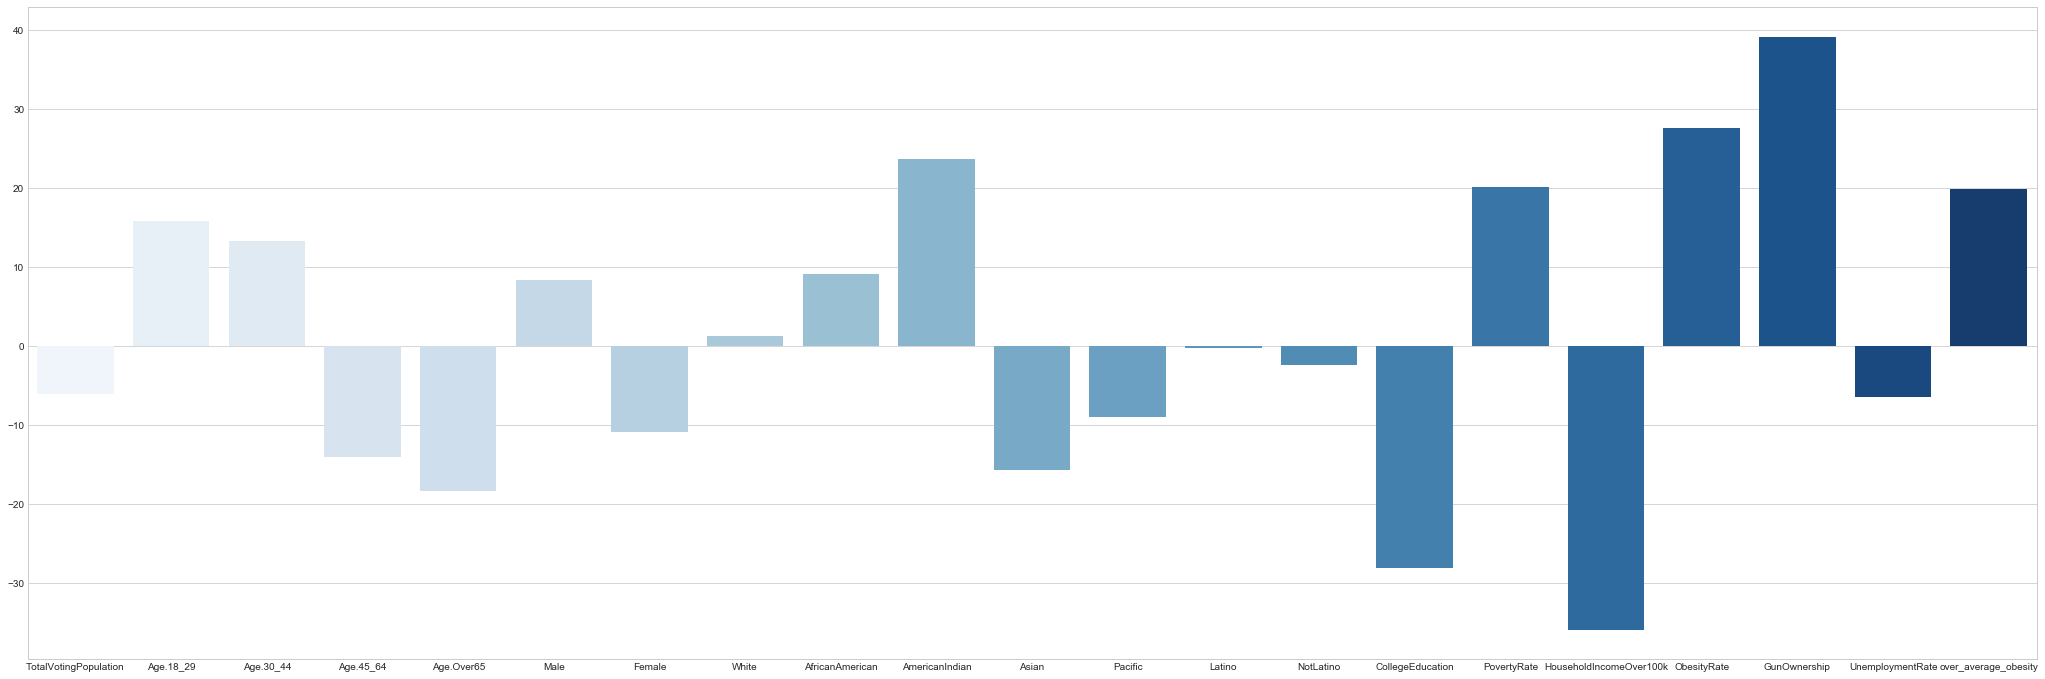

Precision at 1%: 0.80
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=17, subsample=0.5, verbose=0,
              warm_start=False)


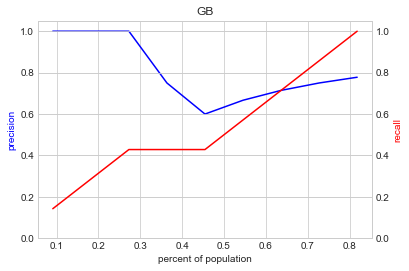

FEATURE IMPORTANCES
{'TotalVotingPopulation': 6.261766453024072e-07, 'Age.18_29': 0.00012171795975173582, 'Age.30_44': 4.603181359565142e-08, 'Age.45_64': 0.0008775948697177603, 'Age.Over65': 0.01849434206567814, 'Male': 4.738787474907421e-05, 'Female': 1.269889851516427e-07, 'White': 0.0012118085202222515, 'AfricanAmerican': 6.000244451214426e-07, 'AmericanIndian': 0.03786292696744994, 'Asian': 3.063776820867899e-05, 'Pacific': 0.018275667549729042, 'Latino': 0.00017755886410283046, 'NotLatino': 0.01735023560896046, 'CollegeEducation': 0.46307029807343436, 'PovertyRate': 0.03408424406275303, 'HouseholdIncomeOver100k': 0.11595979062104614, 'ObesityRate': 0.2261059472976606, 'GunOwnership': 0.06567387592913146, 'UnemploymentRate': 0.00010367574538815445, 'over_average_obesity': 0.0005508910001271298}


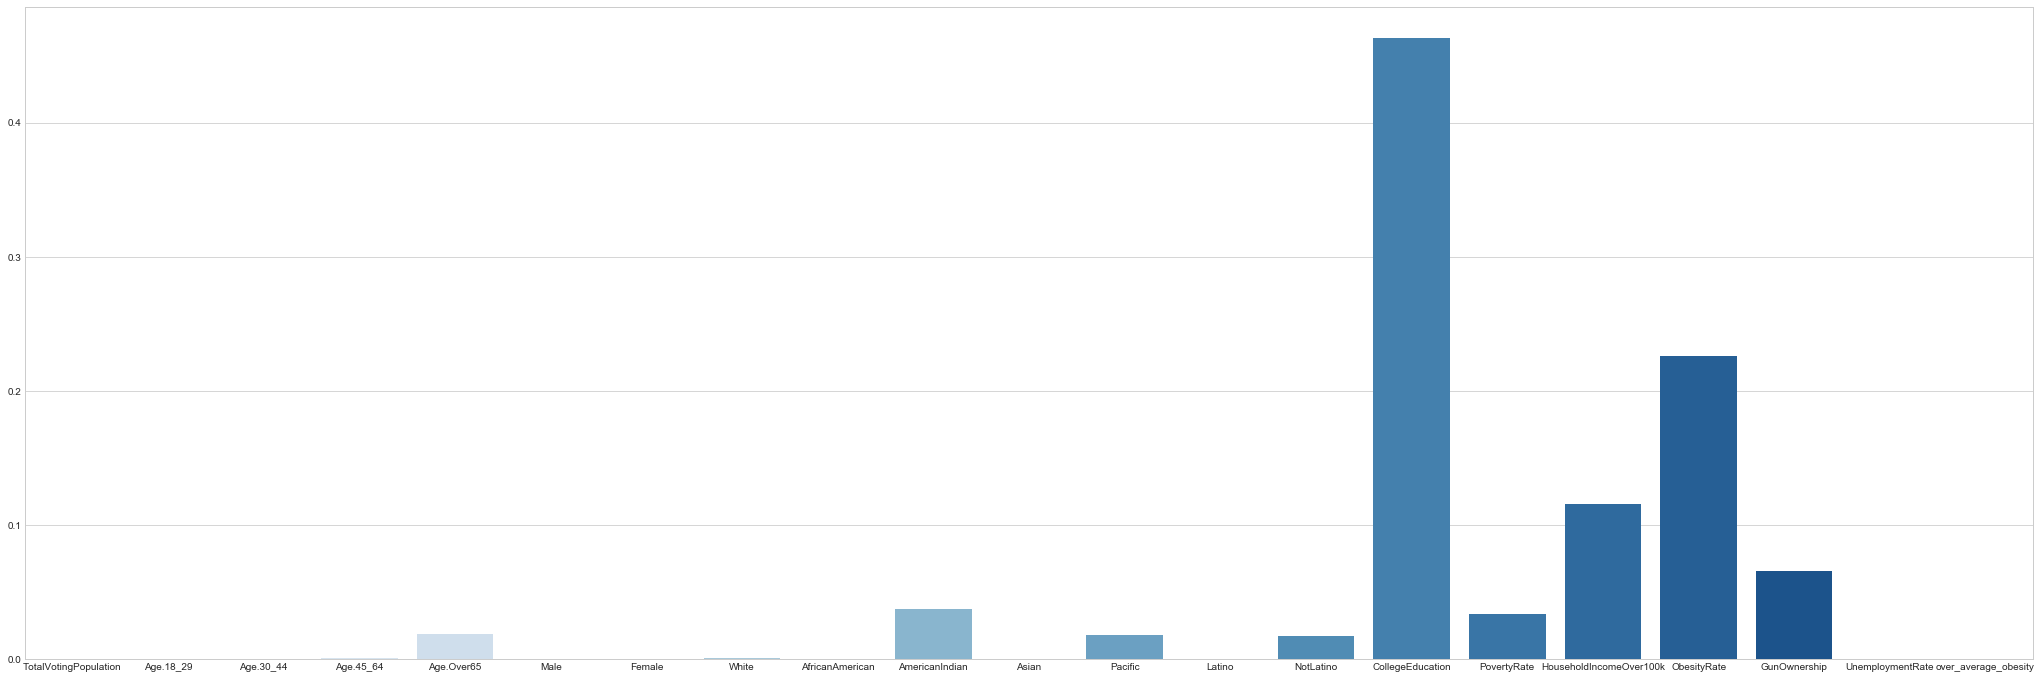

Precision at 1%: 1.00
GaussianNB(priors=None)


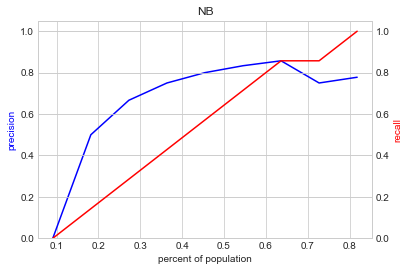

FEATURE IMPORTANCES
{'TotalVotingPopulation': 6.261766453024072e-07, 'Age.18_29': 0.00012171795975173582, 'Age.30_44': 4.603181359565142e-08, 'Age.45_64': 0.0008775948697177603, 'Age.Over65': 0.01849434206567814, 'Male': 4.738787474907421e-05, 'Female': 1.269889851516427e-07, 'White': 0.0012118085202222515, 'AfricanAmerican': 6.000244451214426e-07, 'AmericanIndian': 0.03786292696744994, 'Asian': 3.063776820867899e-05, 'Pacific': 0.018275667549729042, 'Latino': 0.00017755886410283046, 'NotLatino': 0.01735023560896046, 'CollegeEducation': 0.46307029807343436, 'PovertyRate': 0.03408424406275303, 'HouseholdIncomeOver100k': 0.11595979062104614, 'ObesityRate': 0.2261059472976606, 'GunOwnership': 0.06567387592913146, 'UnemploymentRate': 0.00010367574538815445, 'over_average_obesity': 0.0005508910001271298}


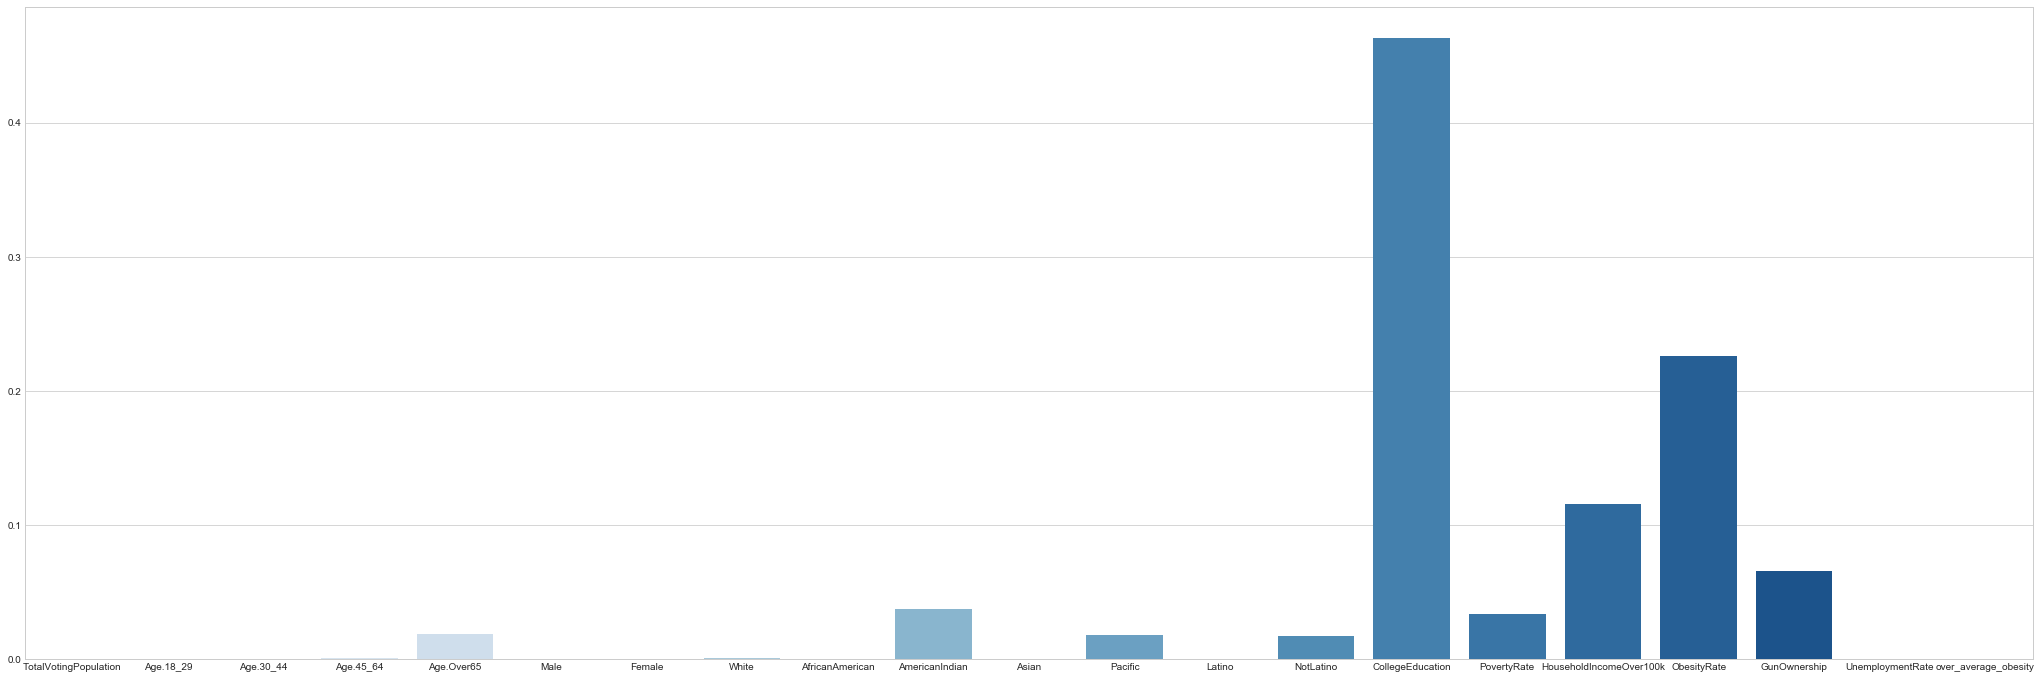

Precision at 1%: 0.00


In [62]:
max_p_at_k = 0
df_results = pd.DataFrame()
for clfNM in sel_clfs:
    clf = clfs[clfNM]
    clf.fit( X_train, y_train )
    print (clf)
    y_score = clf.predict_proba(X_test)[:,1]
    predicted = np.array(y_score)
    expected = np.array(y_test)
    plot_precision_recall_n(expected,predicted, clfNM)
    p_at_1 = precision_at_k(expected,y_score, 0.01)
    p_at_5 = precision_at_k(expected,y_score,0.05)
    p_at_10 = precision_at_k(expected,y_score,0.10)
    fpr, tpr, thresholds = roc_curve(expected,y_score)
    auc_val = auc(fpr,tpr)
    df_results = df_results.append([{
        'clfNM':clfNM,
        'p_at_1':p_at_1,
        'p_at_5':p_at_5,
        'p_at_10':p_at_10,
        'auc':auc_val,
        'clf': clf
    }])
    
    #feature importances
    if hasattr(clf, 'coef_'):
        feature_import = dict(
            zip(sel_features,clf.coef_.ravel()))
    elif hasattr(clf, 'feature_importances_'):
        feature_import = dict(
            zip(sel_features, clf.feature_importances_))
    print("FEATURE IMPORTANCES")
    print(feature_import)
    
    plt.clf()
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(36,12))
    sns.barplot(x=list(feature_import.keys()), y = list(feature_import.values()), palette="Blues")
    plt.show()
    
    if max_p_at_k < p_at_1:
        max_p_at_k = p_at_1
    print('Precision at 1%: {:.2f}'.format(p_at_1))
df_results.to_csv('modelrun.csv')

# Assess Model Against Baselines

- Back to [Table of Contents](#Table-of-Contents)

It is important to check our model against a reasonable **baseline** to know how well our model is doing. Without any context, 78% accuracy can sound really great... but it's not so great when you remember that you could do almost that well by declaring everyone will not need benefits in the next year, which would be stupid (not to mention useless) model. 

A good place to start is checking against a *random* baseline, assigning every example a label (positive or negative) completely at random. 

In [63]:
max_p_at_k

1.0

In [64]:
random_score = [random.uniform(0,1) for i in enumerate(y_test)] 
random_predicted = np.array( [calc_threshold(score,0.5) for score in random_score] )
random_p_at_5 = precision_at_k(expected,random_predicted, 0.01)

Another good practice is checking against an "expert" or rule of thumb baseline. For example, say that talking to people at the IDHS, you find that they think it's much more likely that someone who has been on assistance multiple times already will need assistance in the future. Then you should check that your classifier does better than just labeling everyone who has had multiple past admits as positive.

In [65]:
reenter_predicted = np.array([1 if ObesityRate > mean(df['ObesityRate']) 
                              else 0 for ObesityRate in df_testing.ObesityRate.values])
reenter_p_at_1 = precision_at_k(expected,reenter_predicted,0.01)

In [66]:
all_non_reenter = np.array([0 for ObesityRate in df_testing.ObesityRate.values])
all_non_reenter_p_at_1 = precision_at_k(expected, all_non_reenter,0.01)

Text(0,0.5,'precision at 1%')

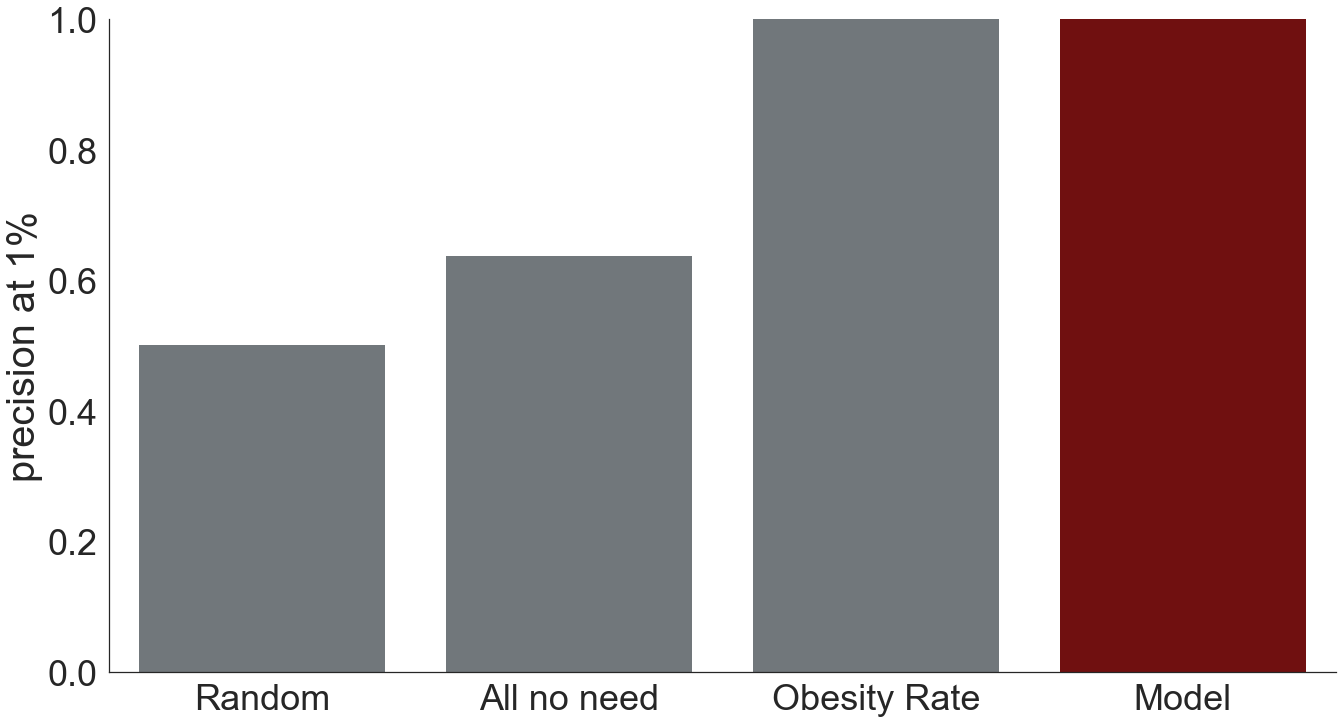

In [67]:
sns.set_style("white")
sns.set_context("poster", font_scale=2.25, rc={"lines.linewidth":2.25, "lines.markersize":8})
fig, ax = plt.subplots(1, figsize=(22,12))
sns.barplot(['Random','All no need', 'Obesity Rate','Model'],
            [random_p_at_5, all_non_reenter_p_at_1, reenter_p_at_1, max_p_at_k],
            palette=['#6F777D','#6F777D','#6F777D','#800000'])
sns.despine()
plt.ylim(0,1)
plt.ylabel('precision at 1%')